# ASDEM Data Analysis
Some analysis and filtering of the data collected.

## Data Collection

In [1]:
import os

# Path of data folder
DATA_PATH = "TrainingDataset/TrainingDataset/TrainingData"
IMAGE_FOLDER = "Images"
TD_FOLDER = "TD_FixMaps"
ASD_FOLDER = "ASD_FixMaps"
IMAGE_PATH = os.path.join(DATA_PATH, IMAGE_FOLDER)
TD_PATH = os.path.join(DATA_PATH, TD_FOLDER)
ASD_PATH = os.path.join(DATA_PATH, ASD_FOLDER)

# Get all image file paths
IMAGE_image_paths = [fn for fn in os.listdir(IMAGE_PATH)]
TD_image_paths = [fn.replace(".png", "_s.png") for fn in IMAGE_image_paths]
ASD_image_paths = TD_image_paths

In [2]:
print(IMAGE_image_paths[0])
print(TD_image_paths[0])
print(ASD_image_paths[0])

176.png
176_s.png
176_s.png


In [3]:
from PIL import Image
import numpy as np

# Load data from fixmaps
def read_fixmap(impath):
    with Image.open(os.path.join(impath)) as im:
        return np.resize(np.array(im.getdata(band=0)), (im.size[1], im.size[0]))

# Load all the image data
IMAGE_images = [Image.open(os.path.join(IMAGE_PATH, fn)).convert("L").getdata(band=0) for fn in IMAGE_image_paths]
TD_images = [read_fixmap(os.path.join(TD_PATH, fn)) for fn in TD_image_paths]
ASD_images = [read_fixmap(os.path.join(ASD_PATH, fn)) for fn in ASD_image_paths]

In [4]:
import pickle

# Average brightness calculator
# Assumes that the images are already converted to grayscale
def mean_brightness(image):
    return (sum(image) / len(image)) / 255

# Get weighted center of fix map
def weighted_center(image):
    center_X = 0
    center_Y = 0
    divisor = 0
    
    for y, row in enumerate(image):
        for x, col in enumerate(row):
            center_X += x * (image[y][x] / 255)
            center_Y += y * (image[y][x] / 255)
            divisor += image[y][x] / 255
    
    center_X /= divisor
    center_Y /= divisor
    
    return (center_X, center_Y)

# Get weighted variance of the fix map
def weighted_variance(image):
    mean = weighted_center(image)
    dist_var = 0
    divisor = 0

    for y, row in enumerate(image):
        for x, col in enumerate(row):
            dist_var += math.sqrt(((mean[1] - y) ** 2) + ((mean[0] - x) ** 2)) * (image[y][x] / 255)
            divisor += image[y][x] / 255

    dist_var /= divisor

    return dist_var

# Get variance of the brightness
# Assumes flat grayscale
def variance_brightness(image):
    return np.var(image)

# Try to fetch existing data
try:
    with open("image_data.bin", "rb") as f:
        image_data = pickle.load(f)
except:
    image_data = {}

# Load missing data into the dataset
if "im_brightness" not in image_data:
    image_data["im_brightness"] = [mean_brightness(im) for im in IMAGE_images]
if "td_center" not in image_data:
    image_data["td_center"] = [weighted_center(im) for im in TD_images]
if "asd_center" not in image_data:
    image_data["asd_center"] = [weighted_center(im) for im in ASD_images]
if "td_var" not in image_data:
    image_data["td_var"] = [weighted_variance(im) for im in TD_images]
if "asd_var" not in image_data:
    image_data["asd_var"] = [weighted_variance(im) for im in ASD_images]
if "im_var" not in image_data:
    image_data["im_var"] = [variance_brightness(im) for im in IMAGE_images]

# Save database to file for later
with open("image_data.bin", "wb") as f:
    pickle.dump(image_data, f)

## Data Analysis
Two kinds of tests will be conducted to analyze the data. The first analysis will be on the difference between the eye movement of the ASD group and the TD group.

### ASD vs TD Analysis
The two-sample t-test will be used to compare the two groups, as the distribution of the data is roughly normal.

In [5]:
import scipy.stats

# The result of the two sample t-test for ASD vs TD
scipy.stats.ttest_ind(image_data["asd_var"], image_data["td_var"])

Ttest_indResult(statistic=7.872427817237647, pvalue=1.641538893176059e-14)

The t-test returns a statistically highly significant result, meaning that there is indeed a difference between the eye movement of the group with ASD and the group without.

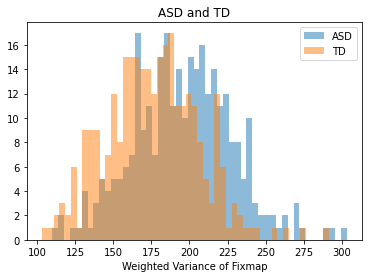

In [6]:
import matplotlib.pyplot as plt

# Plot combined distribution of weighted distance variance
plt.title("ASD and TD")
plt.xlabel("Weighted Variance of Fixmap")
_, _, asd_hist = plt.hist(image_data["asd_var"], 50, alpha=0.5)
_, _, td_hist = plt.hist(image_data["td_var"], 50, alpha=0.5)
plt.legend(handles=[asd_hist, td_hist], labels=["ASD", "TD"])
plt.show()

### Correlation Between Eye Movement and Image Brightness
The Spearman Rank Correlation Coefficient will be used to analyze the correlation between eye movement and image brightness. Image brightness will be measured in mean brightness and variance of brightness.

In [7]:
# The result of the SRCC for ASD on mean image brightness
scipy.stats.spearmanr(image_data["asd_var"], image_data["im_brightness"])

SpearmanrResult(correlation=-0.016487294303270037, pvalue=0.776107313682072)

In [8]:
# The result of the SRCC for TD on mean image brightness
scipy.stats.spearmanr(image_data["td_var"], image_data["im_brightness"])

SpearmanrResult(correlation=0.055664618495761056, pvalue=0.3366227160081139)

The mean brightness of the images do not seem to correlate with the eye movement. The results are statistically insignificant.

In [9]:
# The result of the SRCC for ASD on variance of image brightness
scipy.stats.spearmanr(image_data["asd_var"], image_data["im_var"])

SpearmanrResult(correlation=0.12008222313581261, pvalue=0.03764219096599218)

In [10]:
# The result of the SRCC for TD on variance of image brightness
scipy.stats.spearmanr(image_data["td_var"], image_data["im_var"])

SpearmanrResult(correlation=0.12844142712696807, pvalue=0.026107729793060187)

Although the statistical tests return significant results for variance of brightness, the correlation coefficients return very weak correlations, so we will tentatively disregard the statistical significance.

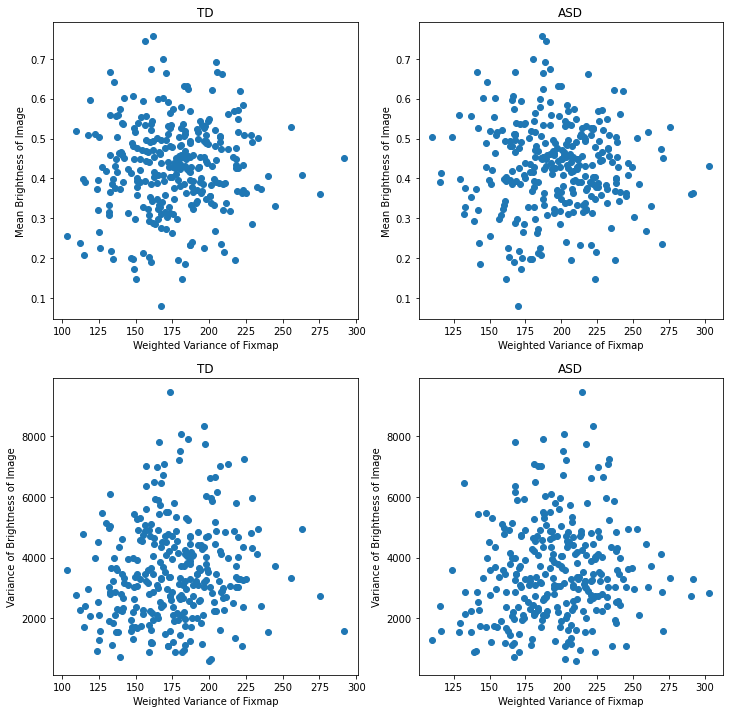

In [11]:
# Plot the combined scatter plots of the data
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 12))

ax1.set_title("TD")
ax1.set_ylabel("Mean Brightness of Image")
ax1.set_xlabel("Weighted Variance of Fixmap")
ax1.plot(image_data["td_var"], image_data["im_brightness"], "o")

ax2.set_title("ASD")
ax2.set_ylabel("Mean Brightness of Image")
ax2.set_xlabel("Weighted Variance of Fixmap")
ax2.plot(image_data["asd_var"], image_data["im_brightness"], "o")

ax3.set_title("TD")
ax3.set_ylabel("Variance of Brightness of Image")
ax3.set_xlabel("Weighted Variance of Fixmap")
ax3.plot(image_data["td_var"], image_data["im_var"], "o")

ax4.set_title("ASD")
ax4.set_ylabel("Variance of Brightness of Image")
ax4.set_xlabel("Weighted Variance of Fixmap")
ax4.plot(image_data["asd_var"], image_data["im_var"], "o")

As indicated by the scatter plots, the weighted distance variance does not seem to correlate at all with the brightness of the images.